In [1]:
import pandas as pd

# Cargar los datos procesados
train_df = pd.read_csv('../data/processed/processed_train_data.csv')
val_df = pd.read_csv('../data/processed/processed_val_data.csv')
test_df = pd.read_csv('../data/processed/processed_test_data.csv')

# Mostrar las primeras filas de cada conjunto de datos
print("Train Data:")
print(train_df.head())

print("\nValidation Data:")
print(val_df.head())

print("\nTest Data:")
print(test_df.head())
print(train_df.info())
print(val_df.info())
print(test_df.info())

Train Data:
                    CommentId      VideoId  \
0        UgiId66Fu7KrDXgCoAEC  04kJtp6pVXI   
1  UgzqKHuL0a2Rw3aQw3J4AaABAg  04kJtp6pVXI   
2        UgimdJUjeexMSXgCoAEC  04kJtp6pVXI   
3        UghKL_Y4vpNs9XgCoAEC  9pr1oE34bIM   
4        UgimA8UbV8KGhHgCoAEC  8HB18hZrhXc   

                                                Text  IsToxic  IsAbusive  \
0  White man can't finish his sentence\nAmerica n...     True       True   
1                                 Yep a Muslim bitch     True      False   
2  "I don't want my sons death to be in vain." "L...     True       True   
3  is this true, police originally said robbery h...    False      False   
4  I'm at this point where I think if a cop point...    False      False   

   IsThreat  IsProvocative  IsObscene  IsHatespeech  IsRacist  IsNationalist  \
0     False          False      False          True      True          False   
1     False          False      False          True     False          False   
2     False   

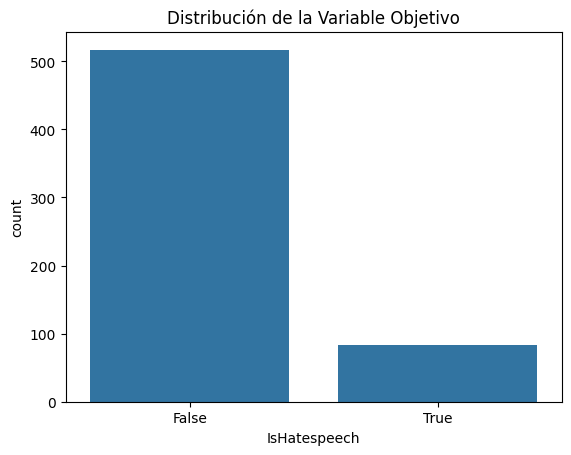

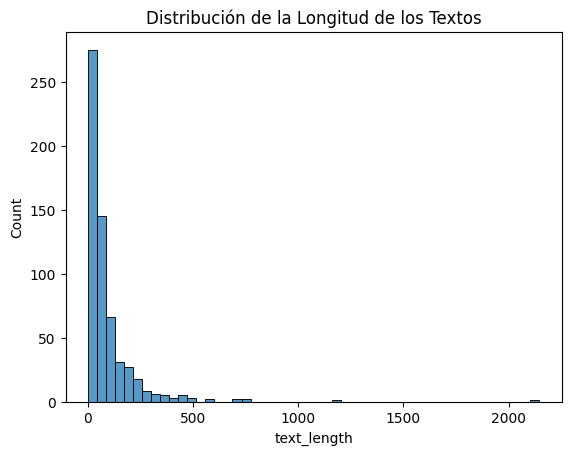

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Distribución de la variable objetivo
sns.countplot(x='IsHatespeech', data=train_df)
plt.title('Distribución de la Variable Objetivo')
plt.show()

# Longitud de los textos
train_df['text_length'] = train_df['processed_text'].apply(lambda x: len(str(x)))#
sns.histplot(train_df['text_length'], bins=50)
plt.title('Distribución de la Longitud de los Textos')
plt.show()


In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import os

def balance_dataset(df, text_column, label_column):
    """
    Balancea el dataset usando directamente los valores numéricos
    ya que el texto ya está procesado como IDs
    """
    # Crear matriz de características usando todas las columnas excepto la etiqueta
    feature_columns = [col for col in df.columns if col != label_column]
    X = df[feature_columns].values
    y = df[label_column].values
    
    # Aplicar SMOTE
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    # Crear DataFrame balanceado
    balanced_df = pd.DataFrame(X_balanced, columns=feature_columns)
    balanced_df[label_column] = y_balanced
    
    return balanced_df

def verify_balance_quality(df_original, df_balanced, label_column):
    """
    Verifica la calidad del balanceo sin depender de procesamiento de texto
    """
    # Calcular distribución de clases
    original_dist = df_original[label_column].value_counts()
    balanced_dist = df_balanced[label_column].value_counts()
    
    print("\n=== Métricas de Balanceo ===")
    print("\nDistribución original:")
    print(original_dist)
    print(f"\nPorcentajes originales:")
    print((original_dist / len(df_original) * 100).round(2))
    
    print("\nDistribución después del balanceo:")
    print(balanced_dist)
    print(f"\nPorcentajes después del balanceo:")
    print((balanced_dist / len(df_balanced) * 100).round(2))
    
    # Verificar otras características estadísticas
    print("\nEstadísticas de características:")
    for col in df_original.columns:
        if col != label_column:
            print(f"\n{col}:")
            print(f"Original - Media: {df_original[col].mean():.2f}, Std: {df_original[col].std():.2f}")
            print(f"Balanceado - Media: {df_balanced[col].mean():.2f}, Std: {df_balanced[col].std():.2f}")

# Crear directorio para métricas si no existe
os.makedirs('../data/metrics', exist_ok=True)

# Procesar cada conjunto de datos
datasets = {
    'train': train_df_encoded,
    'val': val_df_encoded,
    'test': test_df_encoded
}

balance_results = {}

for name, df in datasets.items():
    print(f"\nProcesando conjunto {name}...")
    
    # Balancear datos
    balanced_df = balance_dataset(df, 'processed_text', 'IsHatespeech')
    
    # Verificar balanceo
    verify_balance_quality(df, balanced_df, 'IsHatespeech')
    
    # Guardar resultados
    balance_results[name] = {
        'original_size': len(df),
        'balanced_size': len(balanced_df),
        'original_distribution': df['IsHatespeech'].value_counts().to_dict(),
        'balanced_distribution': balanced_df['IsHatespeech'].value_counts().to_dict()
    }
    
    # Guardar DataFrame balanceado
    balanced_df.to_csv(f'../data/processed/balanced_{name}_data.csv', index=False)

# Guardar reporte de balanceo
import json
with open('../data/metrics/balance_report.json', 'w') as f:
    json.dump(balance_results, f, indent=4)

print("\nProceso de balanceo completado. Los archivos han sido guardados.")


Procesando conjunto train...

=== Métricas de Balanceo ===

Distribución original:
IsHatespeech
0    517
1     83
Name: count, dtype: int64

Porcentajes originales:
IsHatespeech
0    86.17
1    13.83
Name: count, dtype: float64

Distribución después del balanceo:
IsHatespeech
1    517
0    517
Name: count, dtype: int64

Porcentajes después del balanceo:
IsHatespeech
1    50.0
0    50.0
Name: count, dtype: float64

Estadísticas de características:

Text:
Original - Media: 299.50, Std: 173.35
Balanceado - Media: 307.10, Std: 164.18

IsToxic:
Original - Media: 0.45, Std: 0.50
Balanceado - Media: 0.68, Std: 0.47

IsAbusive:
Original - Media: 0.34, Std: 0.47
Balanceado - Media: 0.22, Std: 0.42

IsThreat:
Original - Media: 0.03, Std: 0.16
Balanceado - Media: 0.01, Std: 0.12

IsProvocative:
Original - Media: 0.14, Std: 0.35
Balanceado - Media: 0.08, Std: 0.27

IsObscene:
Original - Media: 0.10, Std: 0.30
Balanceado - Media: 0.06, Std: 0.24

IsRacist:
Original - Media: 0.13, Std: 0.33
Balance